# Datathon V - Día 3 - MLOps

A continuación se detallan las actividades y puntos asignados para el reto de MLOps del Datathon V. Cada actividad tiene un puntaje específico y una evaluación que indica si se ha completado correctamente.

| **Actividad**                                                             | **Puntos**      | **Evaluación** |
| ------------------------------------------------------------------------- | --------------- | -------------- |
| **Tareas de Pipeline y MLFlow**                                           | **Total: 7**    |                |
| Crear un Pipeline de Scikit-Learn                                         | 0.5             | ✅            |
| Lanzar un servidor MLflow local                                           | 0.5             | ✅            |
| Entrenar y evaluar el modelo dentro de una ejecución de MLflow            | 0.5             | ✅            |
| Registrar el modelo y las métricas con MLflow                             | 0.5             | ✅            |
| Registrar el modelo en MLflow                                             | 0.5             | ✅            |
| Desplegar el modelo como una API REST (con Docker)                        | 2.0             | ✅            |
| Hacer predicciones usando la API REST                                     | 2.0             | ✅            |
| Subir las predicciones a la base de datos                                 | 0.5             | ✅            |
| **Código y Documentación**                                                | **Total: 1**    |               |
| Legibilidad del código                                                    | 0.5             | ✅            |
| Documentación en el notebook (títulos, subtítulos, texto)                 | 0.5             | ✅            |
| **Repositorio GIT**                                                       | **Total: 1**    |                |
| Incluir un archivo README.md completo                                     | 0.5             | ✅            |
| Uso de ramas para el desarrollo                                           | 0.5             | ✅            |
| **Puntos Extra (Bonus)**                                                  | **1 + Bonus**   |                |
| Explorar nuevas técnicas, modelos o productos                             | *Bonus*         | ✅              |
| Crear un pequeño artículo y promocionarlo                                 | *Bonus*         | ✅              |
| Cualquier otra iniciativa personal que mejore el proyecto                 | *Bonus*         | ✅              |
| **Evaluaciones Negativas**                                                | **Total: -9.0** |                  |
| Subir datos al repositorio                                                | -3.0            | ❌              |
| Subir contraseñas o información sensible                                  | -3.0            | ❌              |
| Subir archivos generados por MLflow (ej. `mlruns`)                        | -1.0            | ❌              |
| Faltan archivos estándar de Python (ej. `requirements.txt`, `.gitignore`) | -1.0            | ❌              |
| Un archivo README.md con mala presentación                                | -1.0            | ❌              |


**Notes**:
- Puntos Totales: 10 (sin contar los bonus ni los aspectos negativos).
- Los puntos extra pueden mejorar la puntuación, pero no permiten superar el máximo de 10 puntos.
- Las malas prácticas restan puntos.

## 1. Introducción

Lo primero: ¡Enhorabuena! 🎉 Si has llegado hasta aquí, quiere decir que te estas tomando tu formacion muy en serio. 

En este reto de MLOps, vamos a poner en práctica todo lo aprendido hasta ahora. El objetivo es desplegar un modelo registrado en MLFlow y hacer predicciones con él. Finalmente, subiremos los resultados a una base de datos para que puedan ser consultados durante la ultima fase del Datathon. Repasaremos el preprocesamiento de los datos y el entrenamiento del modelo dandole una vuelta: aprenderemos también a simplificar el procesamiento de los datos haciendo uso de un Pipeline de Scikit-Learn.

¿Listo/a? ¡Vamos a ello! 🚀

## 2. Obtención de los datos

En esta sección, vamos a cargar los datos desde la base de datos y vamos a convertir la serie temporal de ventas en un ejercicio Supervisado.

### 2.1 Cargar los datos desde la base de datos

Nos conectamos a la base de datos y ejecutamos una query para obtener los datos de ventas. Utilizamos la librería `pandas` para manejar los datos y `sqlalchemy` para conectarnos a la base de datos.

In [24]:
# Como en los anteriores notebooks, voy a importar varias dependencias
import polars as pl
import pandas as pd
import numpy as np

import os
from dotenv import load_dotenv  # He hecho archivo .env al inicio del proyecto

import plotly.express as px
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError

import sqlalchemy as sa
import sys

In [25]:
class DatabaseConnection:

    # Información necesaria para establecer la conexión a la BBDD
    def __init__(self):
        load_dotenv()  # Variables de entorno
        port = 3306  # Puerto por defecto de MySQL
        user = os.getenv("DB_USER")
        password = os.getenv("DB_PASSWORD")
        host = os.getenv("DB_HOST")
        db_name = os.getenv("DB_NAME") 
        self.engine = create_engine(
            f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{db_name}"
        )
    def check_connection(self) -> bool:
        """Check if DB connection works"""
        try:
            with self.engine.connect() as conn:
                conn.execute(text("SELECT 1"))
            print("Conexión establecida correctamente.")
            return True
        except Exception as e:
            print(f"Error de conexión: {e}")
            return False
    def query_to_pandas(self, sql_query: str) -> pd.DataFrame:
        """Execute a query and get a Pandas"""
        try:
            with self.engine.connect() as conn:
                df = pd.read_sql_query(sql_query, conn)
            print("Consulta ejecutada correctamente (Pandas).")
            return df
        except SQLAlchemyError as e:
            print(f"Error SQLAlchemy: {e}")
            return None
        except Exception as e:
            print(f"Error inesperado: {e}")
            return None
    # En el notebook anterior hago esta función pero de query a Polars, en vista de los problemas que me ha dado, aqui ya usaré Pandas
    def insert_dataframe(self, df: pd.DataFrame, table_name: str) -> None:
        """Inserta un DataFrame de Pandas en la base de datos."""
        try:
            df.to_sql(table_name, self.engine, if_exists="replace", index=False)
            print(f"Tabla '{table_name}' insertada correctamente.")
        except Exception as e:
            print(f"Error insertando DataFrame: {e}")
    

Seteamos las Variables de Configuracion

In [26]:
# Seteadas en archivo .env

Conectamos con la base de datos

In [27]:
database = DatabaseConnection()
database.check_connection()

Conexión establecida correctamente.


True

Realizamos la consulta SQL para obtener los datos de ventas

In [28]:
query = """
    SELECT familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

    FROM ventas_diarias_estudio_completo
"""

# Obtenemos el DataFrame de la base de datos
df = database.query_to_pandas(query)

df.info()

Consulta ejecutada correctamente (Pandas).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10574 entries, 0 to 10573
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   familia                 10574 non-null  object 
 1   articulo                10574 non-null  object 
 2   fecha_venta             10574 non-null  object 
 3   festivo                 837 non-null    object 
 4   precio                  10574 non-null  float64
 5   cantidad                10574 non-null  float64
 6   importe                 10574 non-null  float64
 7   orden_articulo_familia  10574 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 661.0+ KB


In [29]:
# Pequeña comprobación para ver si devuelve resultados
if df is not None and not df.empty:
    print("Datos cargados correctamente:")
    display(df.head())
else:
    print("No se cargaron datos.")

Datos cargados correctamente:


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3880,2021-05-01,None,2.591,3990.000000,10338.089966,3
1,BOLLERIA,3960,2021-05-01,None,2.318,5628.000000,13045.703926,1
2,BOLLERIA,5803,2021-05-01,None,2.727,3318.000000,9048.185730,5
3,BOLLERIA,6286,2021-05-01,None,3.136,2310.000000,7244.160088,4
4,BOLLERIA,6425,2021-05-01,None,31.364,444.149994,13930.309166,2


#### La mayoría de operaciones que hay que hacer ahora, las tengo hechas en el notebook03 de EDA (de Alba y Juan), aunque he usado Polars, así que voy a volver a realizar los siguientes pasos pero con Pandas

In [30]:
print(df.describe())

             precio      cantidad       importe  orden_articulo_familia
count  10574.000000  10574.000000  10574.000000            10574.000000
mean      15.414053   1927.631345   6475.291113                2.961982
std       17.003998   2074.303991   3838.170413                1.395454
min        0.865000     16.800001    126.000000                1.000000
25%        2.591000    210.000000   4030.425002                2.000000
50%        3.545000   1176.000000   5670.000000                3.000000
75%       34.091000   3066.000000   7975.171048                4.000000
max       43.500000  15540.000000  45807.019470                5.000000


In [31]:
# Compruebo las columnas que hay y sus tipos
print(df.columns)
print(df.dtypes)

Index(['familia', 'articulo', 'fecha_venta', 'festivo', 'precio', 'cantidad',
       'importe', 'orden_articulo_familia'],
      dtype='object')
familia                    object
articulo                   object
fecha_venta                object
festivo                    object
precio                    float64
cantidad                  float64
importe                   float64
orden_articulo_familia      int64
dtype: object


Convertimos las fechas a formato datetime y los artículos a tipo int

In [32]:
df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
df["articulo"] = df["articulo"].astype(int)

In [33]:
# Comprobación de tipos
print(df.dtypes)

familia                           object
articulo                           int64
fecha_venta               datetime64[ns]
festivo                           object
precio                           float64
cantidad                         float64
importe                          float64
orden_articulo_familia             int64
dtype: object


### 2.2 Filtramos para un solo producto

Hemos seleccionado el PRODUCT_ID 3960, pero podemos seleccionar cualquier otro producto.

In [34]:
# Voy a seleccionar el producto más vendido
top_sales_product = df.groupby("articulo")["cantidad"].sum().sort_values(ascending=False)
print(top_sales_product.head(1))

articulo
900    4600974.0
Name: cantidad, dtype: float64


In [35]:
# Hemos visto que el artículo 900 es el más vendido
PRODUCT_ID = 900

# Filtramos el DataFrame para el producto deseado
item_df = df.loc[df["articulo"] == PRODUCT_ID].copy()
print(item_df)

        familia  articulo fecha_venta          festivo  precio  cantidad  \
3737  PANADERIA       900  2021-05-01             None   0.865    9114.0   
3742  PANADERIA       900  2021-05-02  Día de la Madre   0.865   12096.0   
3747  PANADERIA       900  2021-05-03   Día de la Cruz   0.865    7770.0   
3752  PANADERIA       900  2021-05-04             None   0.865    6510.0   
3757  PANADERIA       900  2021-05-05             None   0.865    6048.0   
...         ...       ...         ...              ...     ...       ...   
7452  PANADERIA       900  2023-05-14             None   1.050    2940.0   
7457  PANADERIA       900  2023-05-15             None   1.050    2352.0   
7462  PANADERIA       900  2023-05-16             None   1.050    1302.0   
7467  PANADERIA       900  2023-05-17             None   1.050    1722.0   
7472  PANADERIA       900  2023-05-18             None   1.050    2058.0   

           importe  orden_articulo_familia  
3737   7883.609967                       3

Organizamos los datos por fecha y reiniciamos el índice

In [36]:
# Ordenamos por fecha de venta y reseteo del índice
item_df.sort_values("fecha_venta", inplace=True)
item_df.reset_index(inplace=True, drop=True)
display(item_df.head())

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,PANADERIA,900,2021-05-01,None,0.865,9114.0,7883.609967,3
1,PANADERIA,900,2021-05-02,Día de la Madre,0.865,12096.0,10463.040039,3
2,PANADERIA,900,2021-05-03,Día de la Cruz,0.865,7770.0,6721.050021,3
3,PANADERIA,900,2021-05-04,None,0.865,6510.0,5631.150089,3
4,PANADERIA,900,2021-05-05,None,0.865,6048.0,5231.519944,3


### 2.3 Convertimos la serie a formato supervisado

Para poder predecir las ventas, necesitamos transformar los datos en un problema supervisado. Para ello vamos a:

- 👉 Obtener la `cantidad` contabilizada los días anteriores y añadirlos al día presente (shift).
- 👉 Obtener la `cantidad` contabilizada las semanas anteriores y añadirlos al día presente (shift).

👇 Para facilitar el proceso hemos diseñado una función que nos permite transformar la serie a formato supervisado. Esta función recibe como parámetros el dataframe, el número de días y semanas a considerar.

In [37]:
# Prácticamente he usado la misma función, algun "retoque" pero es la misma
def series_to_supervised(
    df: pd.DataFrame,
    target_column: str = "cantidad",
    daily_lag: int = 1,
    weekly_lag: int = 1,
    weekly_period: int = 7,  # Permite cambiar el periodo semanal si fuera necesario
) -> pd.DataFrame:
    """
    Converts a time series dataset into a supervised learning dataset.
    
    Args:
        data: Sequence of observations as a numpy array or DataFrame.
        daily_lag: Number of daily lag observations to include as inputs (X).
        weekly_lag: Number of weekly lag observations to include as inputs (X).
    
    Returns:
        Pandas DataFrame suitable for supervised learning.
    """
    final_df = df.copy()
    target_feature = final_df[target_column]

    # Función interna para crear los lags
    def create_shifted_feature(lag: int, frequency: int, freq_label: str):
        shifted_feature = target_feature.shift(lag * frequency)
        feature_name = f"{target_feature.name} (t-{lag} {freq_label})"
        final_df[feature_name] = shifted_feature

    # Add weekly lagged features
    for lag in range(weekly_lag, 0, -1):
        create_shifted_feature(lag, 7, "weeks")

    # Add daily lagged features
    for lag in range(daily_lag, 0, -1):
        create_shifted_feature(lag, 1, "days")

    return final_df

In [38]:
# Usamos la función con el artículo o ítem seleccionado

item_df_supervised = series_to_supervised(item_df, target_column="cantidad", daily_lag=6, weekly_lag=4)
display(item_df_supervised.head(10))

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
0,PANADERIA,900,2021-05-01,None,0.865,9114.0,7883.609967,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PANADERIA,900,2021-05-02,Día de la Madre,0.865,12096.0,10463.040039,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9114.0
2,PANADERIA,900,2021-05-03,Día de la Cruz,0.865,7770.0,6721.050021,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9114.0,12096.0
3,PANADERIA,900,2021-05-04,None,0.865,6510.0,5631.150089,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9114.0,12096.0,7770.0
4,PANADERIA,900,2021-05-05,None,0.865,6048.0,5231.519944,3,NaN,NaN,NaN,NaN,NaN,NaN,9114.0,12096.0,7770.0,6510.0
5,PANADERIA,900,2021-05-06,None,0.865,6804.0,5885.460065,3,NaN,NaN,NaN,NaN,NaN,9114.0,12096.0,7770.0,6510.0,6048.0
6,PANADERIA,900,2021-05-07,None,0.865,8064.0,6975.359933,3,NaN,NaN,NaN,NaN,9114.0,12096.0,7770.0,6510.0,6048.0,6804.0
7,PANADERIA,900,2021-05-08,None,0.865,11928.0,10317.720074,3,NaN,NaN,NaN,9114.0,12096.0,7770.0,6510.0,6048.0,6804.0,8064.0
8,PANADERIA,900,2021-05-09,None,0.865,9828.0,8501.220014,3,NaN,NaN,NaN,12096.0,7770.0,6510.0,6048.0,6804.0,8064.0,11928.0
9,PANADERIA,900,2021-05-10,None,0.865,5544.0,4795.560036,3,NaN,NaN,NaN,7770.0,6510.0,6048.0,6804.0,8064.0,11928.0,9828.0


## 3. Preprocesamiento de los datos

Hasta ahora en clase hemos visto como podemos modificar los datos de entrada para adaptarlos a los modelos. En este caso vamos a ir un paso más allá y vamos a **crear un Flujo de Transformacion de Datos (Data Pipeline)** que nos permita transformar los datos de entrada en un formato adecuado para el modelo.

Cuales son las transformaciones que vamos a realizar?

- 👉 **Extraer info de la fecha de venta**: el día, el mes, el año, el día de la semana y si es fin de semana o no.
- 👉 **Indicar si el día es festivo o no.**
- 👉 **Agregar informacion meteorológica**: temperatura, humedad, velocidad del viento y precipitaciones...


💡El uso de funciones nos permite reutilizar el codigo tantas veces como queramos.

### 3.1 Extraemos info de la fecha de venta

A traves de la fecha de venta vamos a crear las siguientes columnas:

- 👉 El día de la semana ( `dayofweek`)
- 👉 El día del mes (`day`)
- 👉 El mes (`month`)
- 👉 El año (`year`)
- 👉 Si es fin de semana o no (`weekend`)

In [39]:
# Añadimos columnas relacionadas con fechas
def add_date_columns(df: pd.DataFrame, date_column: str = "fecha_venta") -> pd.DataFrame:
    df = df.copy()    # Así evito modificar el original fuera de la función
    df["day"] = df[date_column].dt.day
    df["month"] = df[date_column].dt.month
    df["year"] = df[date_column].dt.year
    df["dayofweek"] = df[date_column].dt.dayofweek + 1 # Lunes=1...Domingo=7
    df["isWeekend"] = (df["dayofweek"] >= 6).astype(int)  # Entero preparado para ml
    
    
    return df

item_df_tmp = item_df.copy()
item_df_tmp = add_date_columns(item_df_tmp)
display(item_df_tmp.head())

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,day,month,year,dayofweek,isWeekend
0,PANADERIA,900,2021-05-01,None,0.865,9114.0,7883.609967,3,1,5,2021,6,1
1,PANADERIA,900,2021-05-02,Día de la Madre,0.865,12096.0,10463.040039,3,2,5,2021,7,1
2,PANADERIA,900,2021-05-03,Día de la Cruz,0.865,7770.0,6721.050021,3,3,5,2021,1,0
3,PANADERIA,900,2021-05-04,None,0.865,6510.0,5631.150089,3,4,5,2021,2,0
4,PANADERIA,900,2021-05-05,None,0.865,6048.0,5231.519944,3,5,5,2021,3,0


### 3.2 Indicamos si es festivo o no

Para ello sustituimos los valores de la columna `isHoliday` por `True` si el día es festivo y `False` si no lo es. A continuación, eliminamos la columna `festivo`, de tipo `str`, ya que no la vamos a necesitar.

In [40]:
# Añadimos la columna de si es festivo o no
def add_holiday_column(df: pd.DataFrame, holiday_column_name: str = "festivo") -> pd.DataFrame:
    df = df.copy()  # Sin modificar el original
    if holiday_column_name in df.columns:
        df["isHoliday"]  = ~df[holiday_column_name].isna()
        df["isHoliday"] = df["isHoliday"].astype(int)  # Entero (0/1)
        df.drop(columns=[holiday_column_name], inplace=True)
    return df

item_df_tmp = item_df.copy()
item_df_tmp = add_holiday_column(item_df_tmp)
display(item_df_tmp.head())

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,isHoliday
0,PANADERIA,900,2021-05-01,0.865,9114.0,7883.609967,3,0
1,PANADERIA,900,2021-05-02,0.865,12096.0,10463.040039,3,1
2,PANADERIA,900,2021-05-03,0.865,7770.0,6721.050021,3,1
3,PANADERIA,900,2021-05-04,0.865,6510.0,5631.150089,3,0
4,PANADERIA,900,2021-05-05,0.865,6048.0,5231.519944,3,0


### 3.3 Agregamos la información meteorológica

Utilizamos la API de meteostat para obtener los datos meteorológicos.

- 👉 Añadir las condiciones meteorológicas para las fechas en el dataframe
- 👉 Añadir una columna `rain` que indique si ese dia hubo o no lluvia (verdadero/falso).

In [41]:
# Establezco el código correcto para LOCATION con variables de entorno
def get_location_from_env(varname="LOCATION"):
    loc = os.getenv(varname)
    loc = loc.replace("(", "").replace(")", "").replace(" ", "")
    lat, lon = map(float, loc.split(","))
    return (lat, lon)

location = get_location_from_env()


In [42]:
# Añadimos información meteorológica con la API
from datetime import datetime
from meteostat import Point, Daily
import numpy as np


def get_weather_df(start: datetime, end: datetime, location: tuple[float, float]) -> pd.DataFrame:
    lat, lon = location
    point = Point(lat, lon)
    return Daily(point, start, end).fetch().fillna(0).reset_index()

def merge_dfs_by_column(df1: pd.DataFrame, df2: pd.DataFrame, col_1_name: str, col_2_name: str) -> pd.DataFrame:
    merged_df = df1.reset_index().merge(df2, left_on=col_1_name, right_on=col_2_name, how="inner").set_index("index")
    merged_df.index.name = None
    return merged_df

def add_rain_column(df: pd.DataFrame, precipitation_column_name: str = "prcp") -> pd.DataFrame:
    df = df.copy()
    rain_condition = df[precipitation_column_name] > 0
    df["isRaining"] = np.where(rain_condition, True, False)
    return df

def add_weather_columns(
    df: pd.DataFrame,
    location: tuple[float, float],   # He cambiado de int a float por si las coordenadas tuvieran decimales
    date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
    start = df[date_column_name].min()
    end = df[date_column_name].max()
    weather_df = get_weather_df(start, end, location)
    weather_df = add_rain_column(weather_df)
    weather_df = merge_dfs_by_column(df, weather_df, date_column_name, "time")
    return weather_df

In [43]:
# Vemos el weather df

item_df_tmp = add_weather_columns(item_df_tmp, location)
display(item_df_tmp.head())

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,isHoliday,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,isRaining
0,PANADERIA,900,2021-05-01,0.865,9114.0,7883.609967,3,0,2021-05-01,17.2,11.9,22.8,0.0,0.0,0.0,14.2,0.0,1014.0,0.0,False
1,PANADERIA,900,2021-05-02,0.865,12096.0,10463.040039,3,1,2021-05-02,16.3,10.8,23.2,0.0,0.0,0.0,15.7,0.0,1015.9,0.0,False
2,PANADERIA,900,2021-05-03,0.865,7770.0,6721.050021,3,1,2021-05-03,15.3,12.7,20.1,6.5,0.0,0.0,9.7,0.0,1017.7,0.0,True
3,PANADERIA,900,2021-05-04,0.865,6510.0,5631.150089,3,0,2021-05-04,16.5,12.0,20.9,0.0,0.0,0.0,12.1,0.0,1018.0,0.0,False
4,PANADERIA,900,2021-05-05,0.865,6048.0,5231.519944,3,0,2021-05-05,16.7,12.3,21.7,0.0,0.0,0.0,13.8,0.0,1016.5,0.0,False


In [44]:
item_df_tmp

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,isHoliday,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,isRaining
0,PANADERIA,900,2021-05-01,0.865,9114.0,7883.609967,3,0,2021-05-01,17.2,11.9,22.8,0.0,0.0,0.0,14.2,0.0,1014.0,0.0,False
1,PANADERIA,900,2021-05-02,0.865,12096.0,10463.040039,3,1,2021-05-02,16.3,10.8,23.2,0.0,0.0,0.0,15.7,0.0,1015.9,0.0,False
2,PANADERIA,900,2021-05-03,0.865,7770.0,6721.050021,3,1,2021-05-03,15.3,12.7,20.1,6.5,0.0,0.0,9.7,0.0,1017.7,0.0,True
3,PANADERIA,900,2021-05-04,0.865,6510.0,5631.150089,3,0,2021-05-04,16.5,12.0,20.9,0.0,0.0,0.0,12.1,0.0,1018.0,0.0,False
4,PANADERIA,900,2021-05-05,0.865,6048.0,5231.519944,3,0,2021-05-05,16.7,12.3,21.7,0.0,0.0,0.0,13.8,0.0,1016.5,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,PANADERIA,900,2023-05-14,1.050,2940.0,3087.000047,3,0,2023-05-14,19.4,14.1,25.5,0.0,0.0,0.0,12.6,31.5,1018.2,0.0,False
744,PANADERIA,900,2023-05-15,1.050,2352.0,2469.599961,3,0,2023-05-15,23.8,15.9,32.0,0.0,0.0,0.0,15.5,33.3,1015.5,0.0,False
745,PANADERIA,900,2023-05-16,1.050,1302.0,1367.100021,3,0,2023-05-16,22.3,17.8,26.2,0.0,0.0,0.0,17.6,31.5,1013.0,0.0,False
746,PANADERIA,900,2023-05-17,1.050,1722.0,1808.100015,3,0,2023-05-17,19.2,17.2,23.0,0.0,0.0,0.0,9.5,27.8,1013.4,0.0,False


## 4. Creación del Pipeline 

Sklearn nos permite crear un Pipeline de Transformación de Datos que nos permite aplicar las transformaciones de manera secuencial. Al final del pipeline incluiríamos el modelo de Machine Learning que queremos utilizar. De esta manera, podemos aplicar las transformaciones de manera automática cada vez que entrenamos el modelo. Aumentamos la reusabilidad del código y la legibilidad del mismo. Los pasos del pipeline son:

1. Aplicar las transformaciones de los datos de entrada.
2. Normalizar los datos de entrada utilizando OneHotEncoder y MinMaxScaler.
3. Rellenar los valores nulos calculando la media de cada columna.
4. Incluir un modelo de Machine Learning al final del pipeline.
5. Normalizar la variable objetivo (target) utilizando MinMaxScaler.

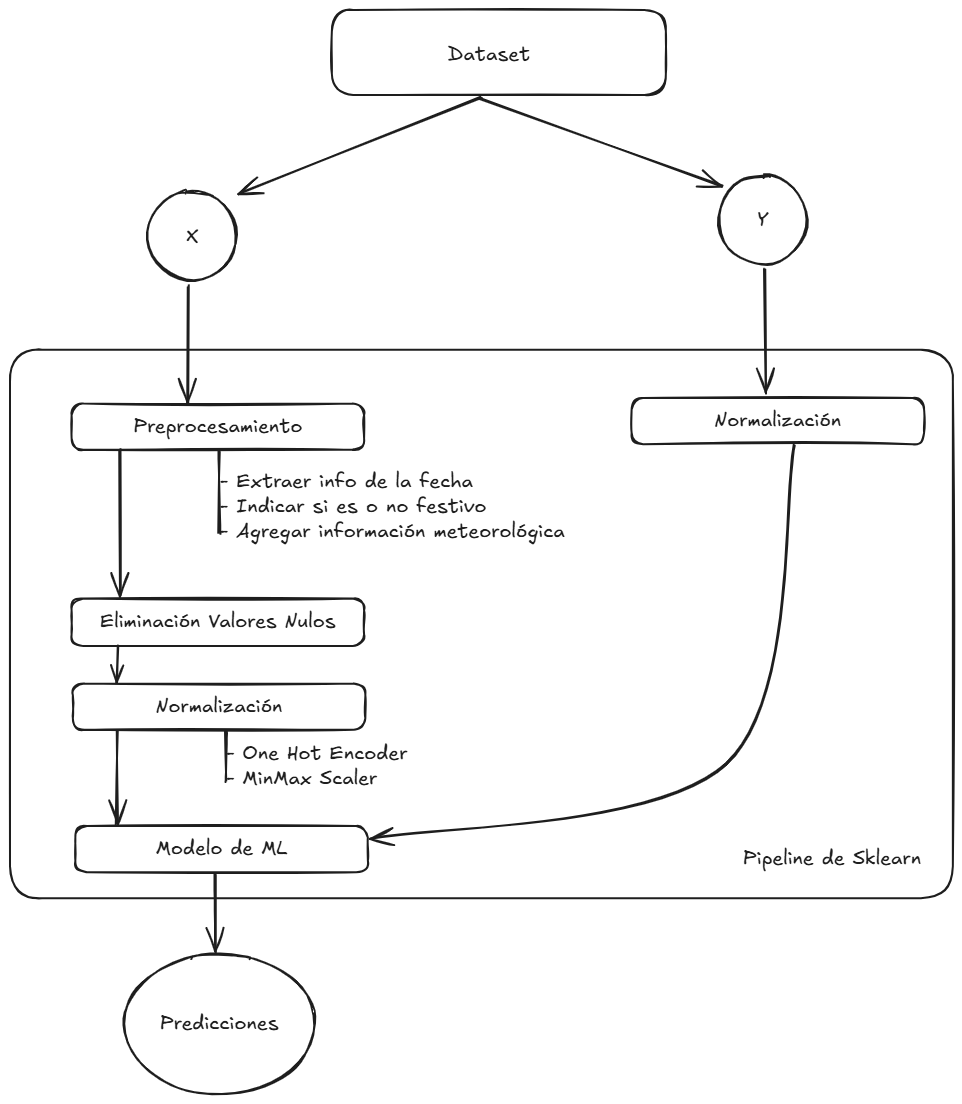

### 4.1 Paso 1: Preprocesamiento de los datos de entrada

Agregamos todas las transformaciones que hemos desarrollado en la sección anterior en un Pipeline de Transformación de Datos.

In [45]:
# Pipeline de transformación de datos
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

class PreprocessTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[float, float]):
        self.location = location

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        # No necesita que aprenda nada, solamente devuelve self
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X = add_date_columns(X)
        X = add_holiday_column(X)
        X = add_weather_columns(X, location=self.location)
        return X
       

In [46]:
# Probamos la función
preprocessor = PreprocessTransformer(location=location)
df_preprocessed = preprocessor.fit_transform(item_df_supervised)
display(df_preprocessed.head())

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),...,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,isRaining
0,PANADERIA,900,2021-05-01,0.865,9114.0,7883.609967,3,NaN,NaN,NaN,...,11.9,22.8,0.0,0.0,0.0,14.2,0.0,1014.0,0.0,False
1,PANADERIA,900,2021-05-02,0.865,12096.0,10463.040039,3,NaN,NaN,NaN,...,10.8,23.2,0.0,0.0,0.0,15.7,0.0,1015.9,0.0,False
2,PANADERIA,900,2021-05-03,0.865,7770.0,6721.050021,3,NaN,NaN,NaN,...,12.7,20.1,6.5,0.0,0.0,9.7,0.0,1017.7,0.0,True
3,PANADERIA,900,2021-05-04,0.865,6510.0,5631.150089,3,NaN,NaN,NaN,...,12.0,20.9,0.0,0.0,0.0,12.1,0.0,1018.0,0.0,False
4,PANADERIA,900,2021-05-05,0.865,6048.0,5231.519944,3,NaN,NaN,NaN,...,12.3,21.7,0.0,0.0,0.0,13.8,0.0,1016.5,0.0,False


In [47]:
# Check columnas
df_preprocessed.columns

Index(['familia', 'articulo', 'fecha_venta', 'precio', 'cantidad', 'importe',
       'orden_articulo_familia', 'cantidad (t-4 weeks)',
       'cantidad (t-3 weeks)', 'cantidad (t-2 weeks)', 'cantidad (t-1 weeks)',
       'cantidad (t-6 days)', 'cantidad (t-5 days)', 'cantidad (t-4 days)',
       'cantidad (t-3 days)', 'cantidad (t-2 days)', 'cantidad (t-1 days)',
       'day', 'month', 'year', 'dayofweek', 'isWeekend', 'isHoliday', 'time',
       'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'isRaining'],
      dtype='object')

### 4.2 Paso 2: Eliminar los valores nulos

En este paso simplemente rellenamos los valores nulos calculando la media de cada columna.

In [48]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

# Solo columnas numéricas
numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

# Imputador de la media
nans_remover = SimpleImputer(strategy="mean")

# ColumnTransformer para aplicar el imputador solo a las numéricas
remove_nans_transformer = ColumnTransformer(
    transformers=[
        ("RemoveNans", nans_remover, numerical_features),
    ],
    remainder="passthrough"   # Deja el resto de columnas como estan
)


In [49]:
# Probamos
df_no_nans = remove_nans_transformer.fit_transform(df_preprocessed)

# Aquí el resultado es un array de numpy, no un DataFrame (muchos errores de este tipo préviamente)
df_no_nans = pd.DataFrame(
    df_no_nans,
    columns=remove_nans_transformer.get_feature_names_out()
)

df_no_nans.head()


,RemoveNans__articulo,RemoveNans__precio,RemoveNans__cantidad,RemoveNans__importe,RemoveNans__orden_articulo_familia,RemoveNans__cantidad (t-4 weeks),RemoveNans__cantidad (t-3 weeks),RemoveNans__cantidad (t-2 weeks),RemoveNans__cantidad (t-1 weeks),RemoveNans__cantidad (t-6 days),...,RemoveNans__pres,RemoveNans__tsun,remainder__familia,remainder__fecha_venta,remainder__day,remainder__month,remainder__year,remainder__dayofweek,remainder__time,remainder__isRaining
0,900.0,0.865,9114.0,7883.609967,3.0,6268.266667,6234.082531,6209.820163,6189.190283,6183.169811,...,1014.0,0.0,PANADERIA,2021-05-01,1,5,2021,6,2021-05-01,False
1,900.0,0.865,12096.0,10463.040039,3.0,6268.266667,6234.082531,6209.820163,6189.190283,6183.169811,...,1015.9,0.0,PANADERIA,2021-05-02,2,5,2021,7,2021-05-02,False
2,900.0,0.865,7770.0,6721.050021,3.0,6268.266667,6234.082531,6209.820163,6189.190283,6183.169811,...,1017.7,0.0,PANADERIA,2021-05-03,3,5,2021,1,2021-05-03,True
3,900.0,0.865,6510.0,5631.150089,3.0,6268.266667,6234.082531,6209.820163,6189.190283,6183.169811,...,1018.0,0.0,PANADERIA,2021-05-04,4,5,2021,2,2021-05-04,False
4,900.0,0.865,6048.0,5231.519944,3.0,6268.266667,6234.082531,6209.820163,6189.190283,6183.169811,...,1016.5,0.0,PANADERIA,2021-05-05,5,5,2021,3,2021-05-05,False


In [50]:
# A colación con el tipado np.array que nos dan devuelve algunas funciones, establezco una función para automatizar

def transformer_output_to_df(transformer, array, index=None):
    """
    Convierte la salida de un transformer de sklearn a un DataFrame de pandas
    con los nombres de columnas correctos.
    
    Args:
        transformer: el transformer fitted (por ejemplo, ColumnTransformer).
        array: numpy array (output de transformer.transform o fit_transform).
        index: (opcional) el índice a usar para el DataFrame (por defecto None).
    
    Returns:
        pd.DataFrame
    """
    columns = transformer.get_feature_names_out()
    return pd.DataFrame(array, columns=columns, index=index)

# Así queda automatizado por si necesitamos la función más adelante

In [51]:
type(df_no_nans)

pandas.core.frame.DataFrame

### 4.3 Paso 3: Normalización de los datos de entrada

Usamos `OneHotEncoder` para las variables categoricas y `MinMaxScaler`. para las variables numéricas.

In [52]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector

categorical_features = make_column_selector(dtype_include=[object, np.int32])
numerical_features = make_column_selector(dtype_include=[np.float64])
# He añadido variables categóricas porque veo que me ayudaran en la estacionalidad

# Variables de preprocesamiento
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

encoders_transformer = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe_encoder, categorical_features),
        ("MinMaxScaler", minmax_scaler, numerical_features),
    ],
    remainder="drop"    # Por si queremos conservar solo las variables codificadas o escaladas
)

### 4.4 Incluimos el modelo de Machine Learning

Como nos encontramos en un problema de regresión, vamos a utilizar un modelo de regresión. En este caso, vamos a utilizar el modelo `LinearRegression` de Scikit-Learn.

In [53]:
# Asignamos model al modelo elegido
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model
# De momento LinearRegression, posteriormente veremos si es el mejor modelo

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 4.5 Creamos el pipeline para las variables de entrada

Agregamos los pasos anteriores al pipeline de transformación de datos de forma secuencial. El pipeline se encargará de aplicar las transformaciones a los datos de entrada y de entrenar el modelo.

In [54]:
# No cambio nada en esta celda, definimos el pipeline 
from sklearn.pipeline import Pipeline


input_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("model", model),
    ]
)

input_pipeline.set_output(transform="pandas")

,steps,"[('preprocessor', ...), ('nan_remover', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,location,"(36.721477644071705, ...)"
,transformers,"[('RemoveNans', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


### 4.6 Paso 5: Normalizamos la variable objetivo

En ultimo paso, usamos el mismo `OneHotEncoder` utilizado para los datos de entrada para codificar la variable objetivo (target), pero sin ajustarlo nuevamente. Esto asegura que la variable objetivo esté en el mismo formato que los datos de entrada, facilitando así la predicción y evaluación del modelo.

In [55]:
# Dejamos la celda igual también
from sklearn.compose import TransformedTargetRegressor


target_feature_scaler = MinMaxScaler(feature_range=(0,1))
final_pipeline = TransformedTargetRegressor(
    regressor=input_pipeline,
    transformer=target_feature_scaler,
)
final_pipeline

,regressor,Pipeline(step...egression())])
,transformer,MinMaxScaler()
,func,None
,inverse_func,None
,check_inverse,True
,location,"(36.721477644071705, ...)"
,transformers,"[('RemoveNans', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


## 5. Entrenamos el modelo

Utilizamos el pipeline creado anteriormente para entrenar el modelo. Marcamos el horizonte de tiempo del conjunto de test a 30 días. Esto significa que el modelo se evaluará con los datos de los últimos 30 días y se entrenará con los datos previos a dicho horizonte. Elegimos un solo producto para simplificar el proceso de entrenamiento y evaluación del modelo.

In [56]:
# Vamos a entrenar el modelo con el producto más vendido como he declarado anteriormente
PRODUCT_ID = 900

item_mask = df["articulo"] == PRODUCT_ID
item_df = df[item_mask].copy()
item_df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
3737,PANADERIA,900,2021-05-01,None,0.865,9114.0,7883.609967,3
3742,PANADERIA,900,2021-05-02,Día de la Madre,0.865,12096.0,10463.040039,3
3747,PANADERIA,900,2021-05-03,Día de la Cruz,0.865,7770.0,6721.050021,3
3752,PANADERIA,900,2021-05-04,None,0.865,6510.0,5631.150089,3
3757,PANADERIA,900,2021-05-05,None,0.865,6048.0,5231.519944,3


Guardamos la familia a la que pertenece el producto para guardarlo como tag en MLFlow

In [57]:
# Guardamos familia
item_df = item_df.reset_index(drop=True)
product_family = item_df["familia"][0]
product_family


'PANADERIA'

In [58]:
item_df

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,PANADERIA,900,2021-05-01,None,0.865,9114.0,7883.609967,3
1,PANADERIA,900,2021-05-02,Día de la Madre,0.865,12096.0,10463.040039,3
2,PANADERIA,900,2021-05-03,Día de la Cruz,0.865,7770.0,6721.050021,3
3,PANADERIA,900,2021-05-04,None,0.865,6510.0,5631.150089,3
4,PANADERIA,900,2021-05-05,None,0.865,6048.0,5231.519944,3
...,...,...,...,...,...,...,...,...
743,PANADERIA,900,2023-05-14,None,1.050,2940.0,3087.000047,3
744,PANADERIA,900,2023-05-15,None,1.050,2352.0,2469.599961,3
745,PANADERIA,900,2023-05-16,None,1.050,1302.0,1367.100021,3
746,PANADERIA,900,2023-05-17,None,1.050,1722.0,1808.100015,3


### 5.1 Pequeña limpieza previa de los datos

Eliminamos las columnas que no vamos a utilizar

In [59]:
# Pequeño ajuste por si alguna columna no existe al re-ejecutar el notebook varias veces
item_df.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
print(item_df.head())
print(item_df.tail())


  fecha_venta          festivo  precio  cantidad
0  2021-05-01             None   0.865    9114.0
1  2021-05-02  Día de la Madre   0.865   12096.0
2  2021-05-03   Día de la Cruz   0.865    7770.0
3  2021-05-04             None   0.865    6510.0
4  2021-05-05             None   0.865    6048.0
    fecha_venta festivo  precio  cantidad
743  2023-05-14    None    1.05    2940.0
744  2023-05-15    None    1.05    2352.0
745  2023-05-16    None    1.05    1302.0
746  2023-05-17    None    1.05    1722.0
747  2023-05-18    None    1.05    2058.0


Reorganizamos el dataframe para que el orden de las fechas sea ascendente

In [60]:
# Nos aseguramos de las fechas sean ascendentes
item_df.sort_values("fecha_venta", inplace=True)
item_df.reset_index(inplace=True, drop=True)
print(item_df.head())
print(item_df.tail())

  fecha_venta          festivo  precio  cantidad
0  2021-05-01             None   0.865    9114.0
1  2021-05-02  Día de la Madre   0.865   12096.0
2  2021-05-03   Día de la Cruz   0.865    7770.0
3  2021-05-04             None   0.865    6510.0
4  2021-05-05             None   0.865    6048.0
    fecha_venta festivo  precio  cantidad
743  2023-05-14    None    1.05    2940.0
744  2023-05-15    None    1.05    2352.0
745  2023-05-16    None    1.05    1302.0
746  2023-05-17    None    1.05    1722.0
747  2023-05-18    None    1.05    2058.0


Convertimos la serie a formato supervisado

In [61]:
# Usamos la función series_to_supervised con el artículo
item_df = series_to_supervised(item_df, daily_lag=6, weekly_lag=4)
print(item_df.head())
print(item_df.tail())


  fecha_venta          festivo  precio  cantidad  cantidad (t-4 weeks)  \
0  2021-05-01             None   0.865    9114.0                   NaN   
1  2021-05-02  Día de la Madre   0.865   12096.0                   NaN   
2  2021-05-03   Día de la Cruz   0.865    7770.0                   NaN   
3  2021-05-04             None   0.865    6510.0                   NaN   
4  2021-05-05             None   0.865    6048.0                   NaN   

   cantidad (t-3 weeks)  cantidad (t-2 weeks)  cantidad (t-1 weeks)  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   cantidad (t-6 days)  cantidad (t-5 days)  cantidad (t-4 days)  \
0                  NaN                  NaN                 

In [62]:
# Compruebo las columnas (checkeo por si parece que esté todo correcto)
print(item_df)

    fecha_venta          festivo  precio  cantidad  cantidad (t-4 weeks)  \
0    2021-05-01             None   0.865    9114.0                   NaN   
1    2021-05-02  Día de la Madre   0.865   12096.0                   NaN   
2    2021-05-03   Día de la Cruz   0.865    7770.0                   NaN   
3    2021-05-04             None   0.865    6510.0                   NaN   
4    2021-05-05             None   0.865    6048.0                   NaN   
..          ...              ...     ...       ...                   ...   
743  2023-05-14             None   1.050    2940.0                2688.0   
744  2023-05-15             None   1.050    2352.0                3276.0   
745  2023-05-16             None   1.050    1302.0                2856.0   
746  2023-05-17             None   1.050    1722.0                2184.0   
747  2023-05-18             None   1.050    2058.0                2226.0   

     cantidad (t-3 weeks)  cantidad (t-2 weeks)  cantidad (t-1 weeks)  \
0             

### 5.2 Dividimos en conjuntos de entrenamiento y test

In [63]:
# train/test del artículo 900
horizont = datetime(2023,4,19)

df_train = item_df[item_df["fecha_venta"] < horizont]
df_test = item_df[item_df["fecha_venta"] >= horizont]

print("Train set size:", df_train.shape[0])
print("Test set size:", df_test.shape[0])
print("Primer día test:", df_test["fecha_venta"].min())
print("Último día test:", df_test["fecha_venta"].max())

print("Primer día train:", df_train["fecha_venta"].min())
print("Último día train:", df_train["fecha_venta"].max())



X_train = df_train.drop(columns=["cantidad"])
y_train = df_train["cantidad"]
X_test = df_test.drop(columns=["cantidad"])
y_test = df_test["cantidad"]

Train set size: 718
Test set size: 30
Primer día test: 2023-04-19 00:00:00
Último día test: 2023-05-18 00:00:00
Primer día train: 2021-05-01 00:00:00
Último día train: 2023-04-18 00:00:00


### 5.3 Iniciar el servidor de MLFlow

- 👉 Lanzar un servidor MLFlow local
- 👉 Conectarse al servidor MLFlow local
- 👉 Establecer el experimento deseado
- 👉 Habilitar el autologging de MLFlow para sklearn

In [64]:
# Errores con el "pip install mflow", así compruebo el Python que estoy usando
import sys
print(sys.executable)

c:\Users\roger\anaconda3\envs\panaderia-datathon\python.exe


In [65]:
import mlflow


In [66]:
# Connect to MLFlow server hosted locally
MLFLOW_EXPERIMENT_NAME = "Panaderia-Datathon"
MLFLOW_TRACKING_URI = "http://localhost:5000"


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.sklearn.autolog()

### 5.4 Entrenamos y evaluamos el modelo

La siguiente sección consiste en entrenar y evaluar el modelo. Veremos como al utilizar el pipeline se simplifica el proceso de entrenamiento y evaluación del modelo. 

💡 El autolog registrará automáticamente las métricas y el modelo

In [67]:
# He añadido dos métricas más, el mse y el r2 score
from sklearn import metrics


with mlflow.start_run() as run:

    mlflow.set_tag("product_family", product_family)
    mlflow.set_tag("product_id", PRODUCT_ID)

    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict(X_test)

    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = metrics.root_mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    mlflow.log_metric('mae', mae)
    mlflow.log_metric('mse', mse)
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)

    print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f}")

MAE: 1165.35 | MSE: 1811603.32 | RMSE: 1345.96 | R2: 0.178
🏃 View run enchanting-shark-197 at: http://localhost:5000/#/experiments/240983069707345815/runs/5e44e148b6024d149d78b3c41c069fdf
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815


### 5.5 Creamos graficos de resultados

Mostramos la diferencia entre las ventas reales y las predicciones

In [ ]:
# Observamos las ventas reales con las predicciones
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Actual Sales")
ax.set_ylabel("Predicted Sales")

# Scatter plot (real vs predict)
sns.scatterplot(x=y_test.values, y=y_pred, ax=ax, label="Predictions")

# Línea ideal (y=x)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
sns.lineplot(x=lims, y=lims, color="red", ax=ax, label="Ideal")

# Save to mlartifacts
fig_path = '../mlartifacts/predictions_vs_ground_truth_article900.png'
plt.savefig(fig_path)
plt.show()


mlflow.log_artifact(fig_path)

Mostramos la diferencia entre las ventas reales y las predicciones a lo largo del tiempo

In [ ]:
# Diferencia clara en el gráfico en ventas reales y predicciones
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")

dates = df_test["fecha_venta"]

sns.lineplot(x=dates, y=y_pred, label="Predicted Sales", ax=ax)
sns.lineplot(x=dates, y=y_test, label="Real Sales", ax=ax)

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()

# Save to MLFlow last run
fig_path = '../mlartifacts/predictions_vs_ground_truth_article900_timeline.png'
plt.savefig(fig_path)
plt.show()
mlflow.log_artifact(fig_path)

In [ ]:
# Vamos a hacer un plot de residuos para ver que sesgo tiene el modelo, si sobrestima o subestima

# Calculamos residuos
residuos = y_test.values - y_pred

# Gráfico de residuos por fecha
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Residuos de la predicción (real - predicho)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Residuo")

ax.axhline(0, color="red", linestyle="--", lw=1, label="Residuo cero")
ax.plot(df_test["fecha_venta"], residuos, marker="o", label="Residuos")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

fig_path = "../mlartifacts/residuos_article900_tiempo.png"
plt.savefig(fig_path)
plt.show()
mlflow.log_artifact(fig_path)

## Análisis de Resultados – Producto 900

A continuación, se analizan los resultados obtenidos al aplicar un modelo de regresión lineal sobre la serie de ventas del producto 900. Se muestran tres gráficos clave para evaluar el desempeño del modelo: **scatterplot predicción vs realidad**, **evolución temporal de las ventas** y **residuos de predicción**.

---

### 1. Scatterplot: Predicted Sales vs Actual Sales

![Scatterplot](../mlartifacts/predictions_vs_ground_truth.png)

- Cada punto representa un día del conjunto de test, comparando la venta real (eje X) con la predicha por el modelo (eje Y).
- La **línea roja** indica la predicción perfecta (y = x).  
- **Observación:** La mayoría de los puntos se sitúan por debajo de la línea ideal, lo que indica que el modelo tiende a **sobreestimar** las ventas reales en la mayoría de los días. Además, se observa dispersión, especialmente en días con ventas bajas o muy altas, lo que refleja cierta dificultad del modelo para capturar los extremos de la serie.

---

### 2. Evolución temporal: Predicción vs Realidad

![Lineplot](../mlartifacts/predictions_vs_ground_truth_timeline.png)

- Este gráfico muestra la evolución temporal de las ventas reales y las predicciones del modelo a lo largo de las fechas del conjunto de test.
- **Observación:** El modelo sigue razonablemente bien la tendencia general de la serie, pero “suaviza” los picos y valles. Es decir, no es capaz de captar completamente las subidas o bajadas abruptas de las ventas, lo que es un comportamiento típico de los modelos lineales en series con alta volatilidad o estacionalidad.

---

### 3. Residuos: Real – Predicho

![Residuos](../mlartifacts/residuos_tiempo.png)

- El gráfico de residuos muestra la diferencia entre las ventas reales y las predichas para cada día.
- **Observación:** Se observa que el modelo tiende a **sobreestimar las ventas** (residuos negativos) en la última parte de la serie, mientras que en algunos días subestima (residuos positivos), sobre todo en los picos. La magnitud de los errores es variable y no completamente aleatoria, lo que sugiere que hay patrones que el modelo no logra capturar adecuadamente.

---

**Conclusión rápida:**  
El modelo de regresión lineal proporciona una primera aproximación aceptable para la predicción de ventas del producto 900, capturando la tendencia general, pero presenta dificultades para ajustarse a los picos y valles. Los análisis visuales sugieren que podría mejorarse el rendimiento utilizando modelos más flexibles (árboles, boosting) o incorporando nuevas variables explicativas que recojan mejor la variabilidad de la demanda.


### Comprobación de distintos modelos

- Voy a crear un snippet simple para comprobar que modelo podría ser el adecuado y que se acerque más a la realidad. Modelos que tienen el mismo preprocesado para no tener que cambiar (por el momento)

In [ ]:
mlflow.end_run()

In [ ]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

modelos = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42)
}

# Defino el scaler para la variable objetivo (igual para todos)
target_feature_scaler = MinMaxScaler(feature_range=(0,1))

for nombre, modelo in modelos.items():
    # Creo un pipeline Nuevo para cada modelo
    input_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("nans_remover", remove_nans_transformer),
            ("data_encoding", encoders_transformer),
            ("model", modelo)
        ]
    )
    input_pipeline.set_output(transform="pandas")

    # Añadir el TransformedTargetRegressor
    final_pipeline = TransformedTargetRegressor(
        regressor=input_pipeline,
        transformer=target_feature_scaler,
    )

    with mlflow.start_run(run_name=nombre):
        print(f"\nEntrenando y evaluando: {nombre}")

        # Entrenamiento
        final_pipeline.fit(X_train, y_train)
        y_pred = final_pipeline.predict(X_test)

        # Métricas
        mae = metrics.mean_absolute_error(y_test, y_pred)
        mse = metrics.mean_squared_error(y_test, y_pred)
        rmse = metrics.root_mean_squared_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)

        print(f"Para el producto 900 -> MAE: {mae:.2f} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f}")

        # Logging
        mlflow.log_param("modelo", nombre)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)

        # Logging del pipeline COMPLETO
        mlflow.sklearn.log_model(final_pipeline, name="model")


In [ ]:
mlflow.end_run()

## Comparación de modelos: Resultados y Conclusiones

Se han entrenado y evaluado tres modelos de regresión distintos para predecir las ventas del producto 900. A continuación se presentan las principales métricas obtenidas en el conjunto de test:

| Modelo                  | MAE     | RMSE     | R²     |
|-------------------------|---------|----------|--------|
| Linear Regression       | 1165.35 | 1345.96  | 0.178  |
| Random Forest           | 1344.20 | 1670.71  | -0.267 |
| HistGradientBoosting    | 1229.36 | 1556.36  | -0.100 |

**MAE**: error absoluto medio (cuanto menor, mejor)  
**RMSE**: raíz del error cuadrático medio (cuanto menor, mejor)  
**R²**: coeficiente de determinación (más cerca de 1 es mejor; valores negativos indican que el modelo es peor que predecir la media).

---

### Análisis

- **El modelo de regresión lineal es el que mejor se comporta** en este caso: obtiene el menor MAE y RMSE, y es el único con R² positivo (0.178).
- Los modelos de árbol (Random Forest y HistGradientBoosting) no logran mejorar los resultados; de hecho, su R² es negativo, lo que significa que predicen peor que la media de la serie.
- Esto puede deberse a que los patrones de la serie son relativamente lineales o a que los modelos no lineales necesitan ajustes adicionales (más datos, más features, tuning de hiperparámetros...).

---

### Conclusión

Por ahora, la **regresión lineal es el modelo más preciso y robusto** para este problema y conjunto de datos. En el futuro, se puede explorar la mejora de los modelos no lineales ajustando sus hiperparámetros o incorporando nuevas variables explicativas.



#### Vamos a testear algun producto más (individualmente) para comprobar que no se trata de un caso aislado las métricas obtenidas con el producto 900.

In [ ]:
mlflow.end_run()

In [ ]:
# Para automatizar el proceso vamos a crear una función que no haga el pipeline simplemente pasando el ID del producto
def pipeline_product(
        PRODUCT_ID,
        df_original,
        preprocessor,
        remove_nans_transformer,
        encoders_transformer,
        target_feature_scaler,
        modelos,
        horizonte_fecha=pd.Timestamp('2023-04-19')
):
    """
    Ejecutar todo el flujo de análisis, el train y logging para un producto.
    """
    resultados = {}

    item_mask =df_original["articulo"] == PRODUCT_ID
    item_df = df_original[item_mask].copy()
    if item_df.empty:
        print(f"No hay datos para el artículo {PRODUCT_ID}")
        return
    # Preprocesado
    item_df.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True, errors="ignore")
    item_df = item_df.sort_values("fecha_venta")
    item_df = item_df.reset_index(drop=True)

    # Añadir los lags
    item_df = series_to_supervised(item_df, daily_lag=6, weekly_lag=4)
    

    # Columna fecha para el split
    fecha_col = "fecha_venta"
    if not horizonte_fecha:  # Con esto, corta el último mes como test, si no especificamos
        horizonte_fecha = item_df[fecha_col].max() - pd.Timedelta(days=30)
        print(f"Usando {horizonte_fecha()} como corte para train/test")

    df_train = item_df[item_df[fecha_col] < horizonte_fecha]
    df_test = item_df[item_df[fecha_col] >= horizonte_fecha]

    if df_train.empty or df_test.empty:
        print(f"No hay datos suficientes para split train/test en el artículo {PRODUCT_ID}")
        return
    
    X_train = df_train.drop(columns=["cantidad"])
    y_train = df_train["cantidad"]
    X_test = df_test.drop(columns=["cantidad"])
    y_test = df_test["cantidad"]
    fechas_test = df_test[fecha_col].reset_index(drop=True)  # IMPORTANTE GUARDARLAS

    for nombre, model in modelos.items():
        input_pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("nan_remover", remove_nans_transformer),
                ("data_encoding", encoders_transformer),
                ("model", model),
            ]
        )
        input_pipeline.set_output(transform="pandas")

        final_pipeline = TransformedTargetRegressor(
            regressor=input_pipeline,
            transformer=target_feature_scaler,
        )

        with mlflow.start_run(run_name=f"{nombre}-articulo-{PRODUCT_ID}"):
            final_pipeline.fit(X_train, y_train)
            y_pred = final_pipeline.predict(X_test)

            # Métricas
            mae = metrics.mean_absolute_error(y_test, y_pred)
            mse = metrics.mean_squared_error(y_test, y_pred)
            rmse = metrics.root_mean_squared_error(y_test, y_pred)
            r2 = metrics.r2_score(y_test, y_pred)

            print(f"[{nombre}] MAE: {mae:.2f} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f}")

            mlflow.log_param("modelo", nombre)
            mlflow.log_param("product_id", PRODUCT_ID)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.sklearn.log_model(final_pipeline, name="model")

            # Aquí se guardan resultados para plotear después
            resultados[nombre] = {
                "y_test": y_test.reset_index(drop=True),
                "y_pred": y_pred,
                "fechas": fechas_test,
            }

        print(f"Análisis terminado para artículo {PRODUCT_ID}.\n")
    return resultados

In [ ]:
# Vamos a comprobar el artículo propuesto en el notebook, el 3960, y probamos que funcione la función

resultados_3960 = pipeline_product(
    PRODUCT_ID=3960,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)


## Resultados de Modelos de Predicción de Ventas (3960)

Se han evaluado tres modelos de regresión para predecir la demanda del producto utilizando un conjunto de datos de series temporales. A continuación se muestran las principales métricas de rendimiento obtenidas para cada modelo:

| Modelo                  | MAE    | MSE        | RMSE   | R2    |
|-------------------------|--------|------------|--------|-------|
| Linear Regression       | 498.64 | 494,743.92 | 703.38 | 0.418 |
| Random Forest           | 530.71 | 610,572.24 | 781.39 | 0.282 |
| HistGradientBoosting    | 561.23 | 707,769.82 | 841.29 | 0.168 |

**Interpretación rápida:**
- El modelo de **Linear Regression** obtiene el mejor desempeño en todos los indicadores, destacando especialmente en el coeficiente de determinación (*R2*), lo que sugiere que explica mejor la variabilidad de la demanda respecto a los otros modelos probados.
- **Random Forest** y **HistGradientBoosting** muestran un rendimiento inferior, con errores más altos y menor capacidad explicativa.
- Todos los modelos presentan un margen de error moderado, lo que indica que la predicción es útil pero todavía puede mejorarse (por ejemplo, añadiendo nuevas variables, ajustando hiperparámetros o probando otros enfoques).

---

**Métricas clave:**
- **MAE (Error absoluto medio):** Error promedio entre la predicción y el valor real, en unidades de ventas.
- **MSE (Error cuadrático medio):** Penaliza más los errores grandes.
- **RMSE (Raíz del error cuadrático medio):** Interpretable en las mismas unidades que la variable objetivo.
- **R2:** Explica la proporción de la varianza de la variable dependiente explicada por el modelo.



In [ ]:
# Después de aplicar la función, compruebo si ha contado bien los festivos (tenía errores antes)
item_df2 = add_holiday_column(item_df)
print(item_df2[["fecha_venta", "isHoliday"]].head(10))

In [ ]:
print(item_df2["isHoliday"].value_counts())


#### Parece que la función que hace todo el flujo funciona bién, así podemos comprobar individualmente las métricas de todos los productos individualmente, para un análisis lo más preciso posible.

In [ ]:
# Scatter plot del producto 3960, con LinearRegression (mejor modelo aquí)
lr_res = resultados_3960["LinearRegression"]
y_test = lr_res["y_test"]
y_pred = lr_res["y_pred"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales (Producto 3960 - LinearRegression)")
ax.set_xlabel("Actual Sales")
ax.set_ylabel("Predicted Sales")

sns.scatterplot(x=y_test.values, y=y_pred, ax=ax, label="Predicciones")
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, color="red", linestyle="--", label="Ideal")

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Comparación de ventas 3960
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales Over Time (Producto 3960 - LinearRegression)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")

dates = lr_res["fechas"]
sns.lineplot(x=dates, y=y_pred, label="Predicted Sales", ax=ax)
sns.lineplot(x=dates, y=y_test, label="Real Sales", ax=ax)

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Residuos plot
residuos = y_test.values - y_pred

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Residuos de la predicción (real - predicho) - Producto 3960")
ax.set_xlabel("Fecha")
ax.set_ylabel("Residuo")

ax.axhline(0, color="red", linestyle="--", lw=1, label="Residuo cero")
ax.plot(dates, residuos, marker="o", label="Residuos")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Vamos a probar con algun artículo más

articulo_menos_vendido = (
    df.groupby("articulo")["cantidad"]
    .sum()
    .sort_values()
    .index[0]
)

print(f"Artículo menos vendido: {articulo_menos_vendido}")

In [ ]:
# Vamos a comprobar el artículo menos vendido, el 6549

resultados_6549 = pipeline_product(
    PRODUCT_ID=6549,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)


## Resultados de Modelos para Predicción de Ventas (6549)

Se han evaluado los mismos tres modelos de regresión sobre un artículo diferente. Los resultados son los siguientes:

| Modelo                  | MAE   | MSE      | RMSE   | R2    |
|-------------------------|-------|----------|--------|-------|
| Linear Regression       | 91.44 | 11,548.52| 107.46 | 0.097 |
| Random Forest           | 67.81 | 7,688.52 | 87.68  | 0.399 |
| HistGradientBoosting    | 75.47 | 9,012.39 | 94.93  | 0.295 |

**Interpretación rápida:**
- En este caso, el modelo de **Random Forest** ofrece el mejor desempeño global, logrando el menor error absoluto (MAE) y el mayor coeficiente de determinación (*R2*), lo que indica que es el modelo que mejor se ajusta a los datos de este artículo concreto.
- **HistGradientBoosting** también supera a la regresión lineal en todas las métricas.
- El modelo de **Linear Regression** obtiene el peor resultado en este escenario, con un R2 muy bajo, lo que indica una capacidad explicativa limitada para este artículo.

**Métricas clave:**  
- **MAE:** Error medio absoluto en unidades de venta.  
- **MSE:** Error cuadrático medio, penaliza los errores grandes.  
- **RMSE:** Raíz cuadrada del MSE, interpretable en las mismas unidades que la variable objetivo.  
- **R2:** Porcentaje de la varianza explicada por el modelo.



In [ ]:
# Plot 1: Real vs. Predicho (Scatter plot 6549 - Random Forest)
rf_res = resultados_6549["RandomForest"]
y_test = rf_res["y_test"]
y_pred = rf_res["y_pred"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales (Producto 6549 - Random Forest)")
ax.set_xlabel("Actual Sales")
ax.set_ylabel("Predicted Sales")

sns.scatterplot(x=y_test.values, y=y_pred, ax=ax, label="Predicciones")
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, color="red", linestyle="--", label="Ideal")

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Comparación de ventas 6549
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales Over Time (Producto 6549 - RandomForest)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")

dates = rf_res["fechas"]
sns.lineplot(x=dates, y=y_pred, label="Predicted Sales", ax=ax)
sns.lineplot(x=dates, y=y_test, label="Real Sales", ax=ax)

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plot de resiuduos artículo 6549
residuos = y_test.values - y_pred

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Residuos de la predicción (real - predicho) - Producto 6549 - RandomForest")
ax.set_xlabel("Fecha")
ax.set_ylabel("Residuo")

ax.axhline(0, color="red", linestyle="--", lw=1, label="Residuo cero")
ax.plot(dates, residuos, marker="o", label="Residuos")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Tenemos que pasar por la función, todos los artículos que quedan


resultados_417 = pipeline_product(
    PRODUCT_ID=417,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_968 = pipeline_product(
    PRODUCT_ID=968,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_1043 = pipeline_product(
    PRODUCT_ID=1043,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_1084 = pipeline_product(
    PRODUCT_ID=1084,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_3880 = pipeline_product(
    PRODUCT_ID=3880,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_5803 = pipeline_product(
    PRODUCT_ID=5803,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_6286 = pipeline_product(
    PRODUCT_ID=6286,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_6425 = pipeline_product(
    PRODUCT_ID=6425,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_5403 = pipeline_product(
    PRODUCT_ID=5403,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_5404 = pipeline_product(
    PRODUCT_ID=5404,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_6451 = pipeline_product(
    PRODUCT_ID=6451,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

In [ ]:
resultados_6523 = pipeline_product(
    PRODUCT_ID=6523,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

### Resultados por producto:

- Producto 417 (PANADERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 106.42 | RMSE: 143.87 | R2: -0.27  
  
- Producto 900 (PANADERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 1165.35 | RMSE: 1345.96 | R2: 0.18  
  
- Producto 968 (PANADERIA):  
  - **Mejor modelo:** RandomForest  
  - MAE: 502.82 | RMSE: 723.67 | R2: 0.31  

- Producto 1043 (PANADERIA):  
  - **Mejor modelo:** HistGradientBoosting  
  - MAE: 466.89 | RMSE: 654.58 | R2: 0.58  
  
- Producto 1084 (PANADERIA):  
  - **Mejor modelo:** HistGradientBoosting  
  - MAE: 527.15 | RMSE: 762.40 | R2: -0.28  
  
- Producto 3880 (BOLLERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 335.92 | RMSE: 441.21 | R2: 0.49  
  
- Producto 3960 (BOLLERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 498.64 | RMSE: 703.38 | R2: 0.42  
  
- Producto 5803 (BOLLERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 247.12 | RMSE: 314.94 | R2: 0.50  
  
- Producto 6286 (BOLLERIA):  
  - **Mejor modelo:** RandomForest  
  - MAE: 292.04 | RMSE: 471.77 | R2: 0.45  
  
- Producto 6425 (BOLLERIA):  
  - **Mejor modelo:** HistGradientBoosting  
  - MAE: 78.40 | RMSE: 97.71 | R2: 0.23  

- Producto 5403 (PASTELERIA):  
  - **Mejor modelo:** HistGradientBoosting  
  - MAE: 117.58 | RMSE: 157.08 | R2: 0.25  
  

- Producto 5404 (PASTELERIA):  
  - **Mejor modelo:** RandomForest  
  - MAE: 111.50 | RMSE: 175.60 | R2: 0.36  
  
- Producto 6451 (PASTELERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 80.71 | RMSE: 99.83 | R2: 0.24  
  
- Producto 6523 (PASTELERIA):  
  - **Mejor modelo:** RandomForest  
  - MAE: 55.92 | RMSE: 66.66 | R2: 0.26  
 
- Producto 6549 (PASTELERIA):  
  - **Mejor modelo:** RandomForest  
  - MAE: 67.81 | RMSE: 87.68 | R2: 0.40  
  


### Evaluación de modelos: próximos pasos

Tras analizar los resultados de predicción de ventas para todos los productos, hemos identificado varios casos donde los modelos probados (Linear Regression, Random Forest y HistGradientBoosting) presentan un bajo rendimiento, especialmente evidenciado por valores de R² negativos o cercanos a cero y errores elevados.

**Para los siguientes productos es imprescindible explorar otros modelos, ya que los resultados actuales no son satisfactorios:**

- **Producto 417 (PANADERIA)**
- **Producto 900 (PANADERIA)**
- **Producto 1084 (PANADERIA)**

**Además, sería recomendable intentar mejorar el modelo para estos productos, ya que muestran R² bajos o margen de mejora:**

- **Producto 6425 (BOLLERIA)**
- **Producto 5403 (PASTELERIA)**
- **Producto 6451 (PASTELERIA)**
- **Producto 6523 (PASTELERIA)**
- **Producto 5404 (PASTELERIA)**
- **Producto 6549 (PASTELERIA)**

Para todos estos artículos, vamos a explorar y probar otros modelos o técnicas adicionales, con el objetivo de mejorar la precisión de las predicciones. Entre las opciones que consideraremos están:

- Modelos clásicos de series temporales (ARIMA, Prophet)
- Otros algoritmos de machine learning (XGBoost, LightGBM, redes neuronales)
- Técnicas avanzadas de feature engineering o ajuste de hiperparámetros

De este modo, buscamos encontrar la mejor solución para cada producto, garantizando resultados más robustos y fiables en la predicción de la demanda.


In [ ]:
import matplotlib.pyplot as plt

# Filtra las ventas del producto 417
df_417 = df[df["articulo"] == 417].copy()
df_417 = df_417.sort_values("fecha_venta")

plt.figure(figsize=(14, 5))
plt.plot(df_417["fecha_venta"], df_417["cantidad"], marker='o', label="Ventas")
plt.title("Ventas del Producto 417 (PANADERIA) en el tiempo")
plt.xlabel("Fecha")
plt.ylabel("Unidades vendidas")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Con este plot, vamos a analizar los outliers claros que hay, vamos a marcar el umbral en 3 veces la desviación estándar (std)

In [ ]:
# Umbral: 3 veces la desviación estándar
umbral = df_417["cantidad"].mean() + 3 * df_417["cantidad"].std()
outliers = df_417[df_417["cantidad"] > umbral]

print(f"Se han detectado {len(outliers)} posibles outliers:")
print(outliers[["fecha_venta", "cantidad"]])


In [ ]:
# Con seasonal_decompose, podremos descomponer la estacionalidad
from statsmodels.tsa.seasonal import seasonal_decompose

# Reindexa fechas para tener frecuencia diaria y rellena vacíos con 0
df_417_daily = df_417.set_index("fecha_venta").resample("D").sum().fillna(0)

# Descomposición aditiva (puedo ajustar period si tenemos patrón semanal o mensual)
result = seasonal_decompose(df_417_daily["cantidad"], model='additive', period=7)

fig = result.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Descomposición estacional - Producto 417")
plt.tight_layout()
plt.show()


#### Descomposición estacional – Producto 417

El análisis de descomposición estacional para el Producto 417 muestra lo siguiente:

- **Serie original:** Las ventas diarias presentan gran variabilidad y algunos picos, sin una tendencia claramente creciente o decreciente.
- **Tendencia:** Se observa una caída de ventas a finales de 2021, seguida de cierta recuperación y oscilaciones posteriores.
- **Estacionalidad:** Existe un patrón periódico muy marcado con una cadencia semanal, indicando que las ventas varían de forma significativa según el día de la semana.
- **Residuo:** La mayor parte de los residuos oscilan cerca de cero, aunque aparecen algunos valores atípicos (outliers) que podrían deberse a eventos puntuales o errores de registro.

**Conclusión:**  
El producto presenta una **estacionalidad semanal muy fuerte** y cierta variabilidad en la tendencia. Creo que para mejorar las predicciones, es fundamental incorporar variables que recojan el día de la semana y analizar posibles outliers en los datos.


In [ ]:
paraaaaaaaaaaaa

## 6. Productivización del modelo

👇 Utiliza tus conocimientos de MLOps para desplegar un modelo registrado en MLFlow. Si todo ha ido correctamente deberias ver unos logs similares a estos:

```bash
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started parent process [15]
INFO:     Started server process [20]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
```

## 7. Haz peticiones al modelo

Una vez has desplegado el modelo, puedes hacer peticiones al mismo. Aplica los conocimientos de comunicación entre servicios que hemos visto en clase para hacer una petición al modelo. Enviale el conjunto de test y obtendrás las predicciones del modelo.

- ⚠️ Importante: el campo `fecha_venta` debes convertirlo a `string` previamente para que pueda ser enviado al modelo.
- ⚠️ Importante: guarda las predicciones en una variable `predictions` para que puedas utilizarlas posteriormente.

In [ ]:
# 👇 add your code here



## 8. Sube tus resultados a la base de datos

Sube las predicciones devueltas por el modelo desplegado a la base de datos. De esta forma podras utilizarlos en Tableau, PowerBI, etc. Primero creamos el dataframe que subiremos a la base de datos. Este dataframe contendrá las siguientes columnas:

| **Columna**      | **Descripción**                                  |
|------------------|--------------------------------------------------|
| `fecha`          | Fecha de la predicción                           |
| `cantidad`       | Ventas predichas por el modelo                   |
| `articulo`       | ID del producto                                  |
| `familia`        | Familia del producto                             |


In [ ]:
dates = df_test["fecha_venta"].tolist()
predictions = y_pred

# Create a dataframe with the data to store
df_article_prediction = pd.DataFrame({
    "fecha": dates,
    "cantidad": predictions,
    "articulo": [PRODUCT_ID] * len(predictions),  # repeat the article for each date
    "familia": [product_family] * len(predictions),  # repeat the family for each date
})

df_article_prediction.head(5)

Subimos los resultados.

In [ ]:
# Database credentials
DATABASE = "sandbox"
NAME = "Mate"  # ‼️ Cambia esta variable por tu nombre. 

table_name = f"Materials_Prediction_Group_{NAME}"

# Connect to the database
db = DatabaseConnection(DB_USERNAME, DB_PASSWORD, database=DATABASE)
db.insert_dataframe(df_article_prediction, table_name)